In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import torch
import json
import plotly.express as px
from transformer_lens import utils
from datasets import load_dataset
from typing import Dict
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from functools import partial

from huggingface_hub import hf_hub_download
from sae_training.sae_group import SAEGroup

from error_eval import *

from sae_training.utils import LMSparseAutoencoderSessionloader
from sae_analysis.visualizer.data_fns import get_feature_data, FeatureData

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda:1" if torch.cuda.is_available() else "cpu"

torch.set_grad_enabled(False)

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Start by downloading them from huggingface

REPO_ID = "jbloom/GPT2-Small-SAEs"


layer = 6  # any layer from 0 - 11 works here
FILENAME = f"final_sparse_autoencoder_gpt2-small_blocks.{layer}.hook_resid_pre_24576.pt"

# this is great because if you've already downloaded the SAE it won't download it twice!
path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

In [4]:
# We can then load the SAE, dataset and model using the session loader
model, sparse_autoencoder, activation_store = (
    LMSparseAutoencoderSessionloader.load_session_from_pretrained(path=path)
)

sae_group = SAEGroup(sparse_autoencoder['cfg'])
sae = sae_group.autoencoders[0]
sae.load_state_dict(sparse_autoencoder['state_dict'])
sae.eval()

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


/home/wesg/research/mats_sae_training/.venv/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Dataset is not tokenized! Updating config.
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
Using Ghost Grads.
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
Using Ghost Grads.
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.5

SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)

In [5]:
def get_saes(layers):
    saes = {}
    for layer in layers:
        REPO_ID = "jbloom/GPT2-Small-SAEs"
        FILENAME = f"final_sparse_autoencoder_gpt2-small_blocks.{layer}.hook_resid_pre_24576.pt"
        path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
        
        model, sparse_autoencoder, activation_store = (
            LMSparseAutoencoderSessionloader.load_session_from_pretrained(path=path)
        )
        
        sae_group = SAEGroup(sparse_autoencoder['cfg'])
        sae = sae_group.autoencoders[0]
        sae.load_state_dict(sparse_autoencoder['state_dict'])
        sae.eval()
        saes[layer] = sae
        
    return saes, model, activation_store

In [14]:
n_batches = 500
tokens = []
for i in range(n_batches):
    batch = activation_store.get_batch_tokens()
    tokens.append(batch)
token_tensor = torch.concat(tokens)

In [21]:
# torch.save(token_tensor.cpu(), 'token_tensor.pt')

In [6]:
batch = activation_store.get_batch_tokens()

In [8]:
batch

tensor([[50256,   464,  9317,  ...,   257,  6573,  7394],
        [50256,    13,   383,  ...,  8093,  2250,   706],
        [50256,   262,  6318,  ..., 39469,   389,  1593],
        ...,
        [50256,    76,   515,  ...,   815,  1986,  1936],
        [50256,   812, 16510,  ...,    13,   554,  1109],
        [50256,    11,   477,  ...,   460,   307, 13467]], device='cuda:0')

In [18]:
pos = 64
hook_loc = 'resid_pre'

with torch.inference_mode():
    nominal_logits, cache = model.run_with_cache(
        batch.cuda(), 
        prepend_bos=True,
        names_filter=[sae.cfg.hook_point]
    )
    sae_out, feature_acts, loss, mse_loss, l1_loss, _ = sae(
        cache[sae.cfg.hook_point]
    )
    sub_hook = partial(reconstruction_hook, sae_out=sae_out, pos=pos)
    l2_sub_hook = partial(l2_error_preserving_perturbation_hook, sae_out=sae_out, pos=pos)
    
    sae_logits = model.run_with_hooks(
        batch,
        fwd_hooks=[(utils.get_act_name(hook_loc, layer), sub_hook)]
    )
    
    random_logits = model.run_with_hooks(
        batch,
        fwd_hooks=[(utils.get_act_name(hook_loc, layer), l2_sub_hook)]
    )
    

In [57]:
original_log_probs = nominal_logits.log_softmax(dim=-1).cpu()
sae_log_probs = sae_logits.log_softmax(dim=-1).cpu()
random_log_probs = random_logits.log_softmax(dim=-1).cpu()

In [58]:
sae_patch_kl_div = F.kl_div(
    sae_log_probs, 
    original_log_probs,
    log_target=True, 
    reduction='none'
).sum(dim=-1)

random_patch_kl_div = F.kl_div(
    random_log_probs, 
    original_log_probs,
    log_target=True, 
    reduction='none'
).sum(dim=-1)

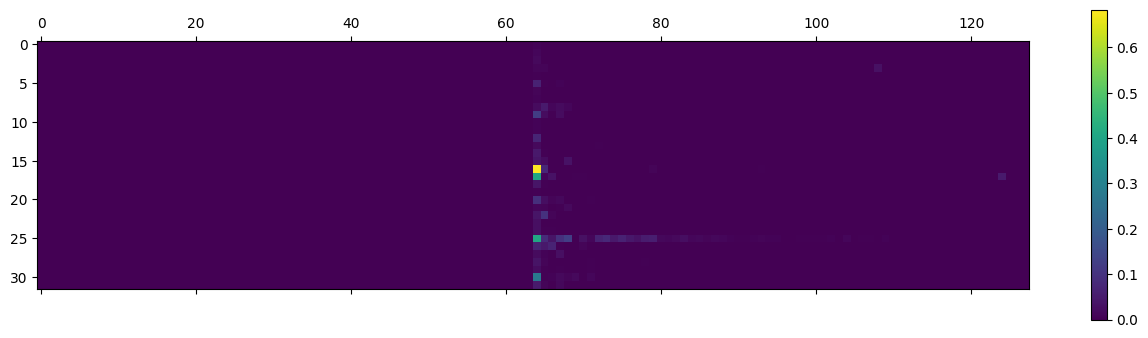

In [28]:
plt.matshow(sae_patch_kl_div.cpu().numpy())
plt.colorbar()


In [105]:
sae_patch_kl_div[:, 64].argmax()

tensor(16)

In [109]:
sae_patch_kl_div[:, 64].sort()

torch.return_types.sort(
values=tensor([0.0035, 0.0040, 0.0061, 0.0068, 0.0071, 0.0074, 0.0094, 0.0104, 0.0124,
        0.0129, 0.0165, 0.0165, 0.0195, 0.0196, 0.0219, 0.0289, 0.0292, 0.0367,
        0.0374, 0.0383, 0.0390, 0.0461, 0.0501, 0.0647, 0.0659, 0.0703, 0.0913,
        0.1235, 0.2736, 0.4011, 0.4097, 0.6837]),
indices=tensor([ 4, 19,  7, 10, 11,  0,  6,  3, 21,  1, 13,  2, 27,  8, 29, 23, 24, 28,
        15, 22, 18, 14, 31, 26,  5, 12, 20,  9, 30, 17, 25, 16]))

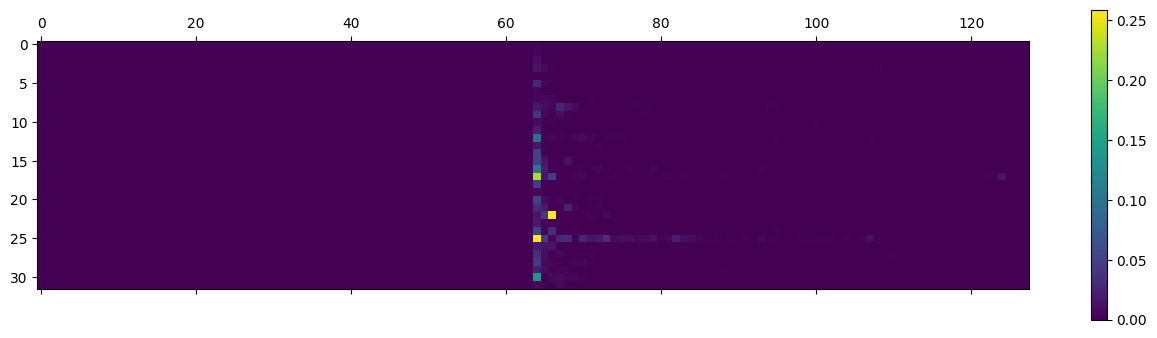

In [27]:
plt.matshow(random_patch_kl_div.cpu().numpy())
plt.colorbar()

In [46]:
sae_patch_kl_div[5, 64], random_patch_kl_div[5, 64]

(tensor(0.0659, device='cuda:0'), tensor(0.0277, device='cuda:0'))

In [89]:
sae_kl

(tensor(0.0659),)

In [113]:
k = 25
seq = 5
pos = 64
def plot_top_token_kl_comparison(nominal_logits, sae_logits, random_logits, seq, pos, k=25, ax=None):
    
    original_log_probs = nominal_logits.log_softmax(dim=-1).cpu()
    sae_log_probs = sae_logits.log_softmax(dim=-1).cpu()
    random_log_probs = random_logits.log_softmax(dim=-1).cpu()
    
    sae_patch_kl_div = F.kl_div(
        sae_log_probs, 
        original_log_probs,
        log_target=True, 
        reduction='none'
    ).sum(dim=-1)

    random_patch_kl_div = F.kl_div(
        random_log_probs, 
        original_log_probs,
        log_target=True, 
        reduction='none'
    ).sum(dim=-1)

    e = 2.718
    sae_kl = sae_patch_kl_div[seq, pos].item()
    random_kl = random_patch_kl_div[seq, pos].item()
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        
    orginal_top_log_p_value, orignal_top_indices = original_log_probs[seq, pos].sort(descending=True)
    ax.plot(orginal_top_log_p_value[:k].cpu().numpy(), label='original')
    ax.plot(sae_log_probs[seq, pos][orignal_top_indices[:k]].cpu().numpy(), label=f'SAE (KL={sae_kl:.3f})')
    ax.plot(random_log_probs[seq, pos][orignal_top_indices[:k]].cpu().numpy(), label=f'$\epsilon$-random (KL={random_kl:.3f})')

    ax.legend(loc='lower left', frameon=False)

    top_log_prob = orginal_top_log_p_value[0]
    top_sae_log_prob = sae_log_probs[seq, pos][orignal_top_indices[0]]
    top_rand_log_prob = random_log_probs[seq, pos][orignal_top_indices[0]]

    top_prob = e ** top_log_prob
    sae_top_prob = e ** top_sae_log_prob
    random_top_prob = e ** top_rand_log_prob

    # add horizontal line from x = 0 to x=5 at y = -1.5
    ax.axhline(y=top_log_prob, color='tab:blue', linestyle='--', xmin=0, xmax=0.2, lw=0.75)
    ax.axhline(y=top_sae_log_prob, color='tab:orange', linestyle='--', xmin=0, xmax=0.37, lw=0.75)
    ax.axhline(y=top_rand_log_prob, color='tab:green', linestyle='--', xmin=0, xmax=0.54, lw=0.75)

    # add annotation to right of the horizontal line with the prob value
    ax.annotate(f'p={top_prob:.3f}', (3.35, top_log_prob), textcoords="offset points", xytext=(10,0), ha='left', va='center', fontsize=9, color='tab:blue')
    ax.annotate(f'p={sae_top_prob:.3f}', (7.5, top_sae_log_prob), textcoords="offset points", xytext=(10,0), ha='left', va='center', fontsize=9, color='tab:orange')
    ax.annotate(f'p={random_top_prob:.3f}', (12, top_rand_log_prob), textcoords="offset points", xytext=(10,0), ha='left', va='center', fontsize=9, color='tab:green')

    ax.set_xlabel('token rank')

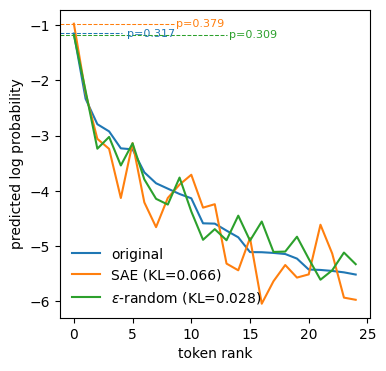

In [102]:
plot_top_token_kl_comparison(
    nominal_logits, sae_logits, random_logits, seq=5, pos=64, k=25
)

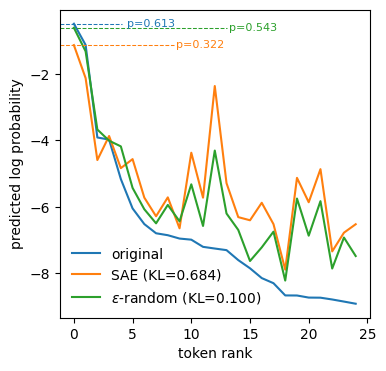

In [106]:
plot_top_token_kl_comparison(
    nominal_logits, sae_logits, random_logits, seq=16, pos=64, k=25
)

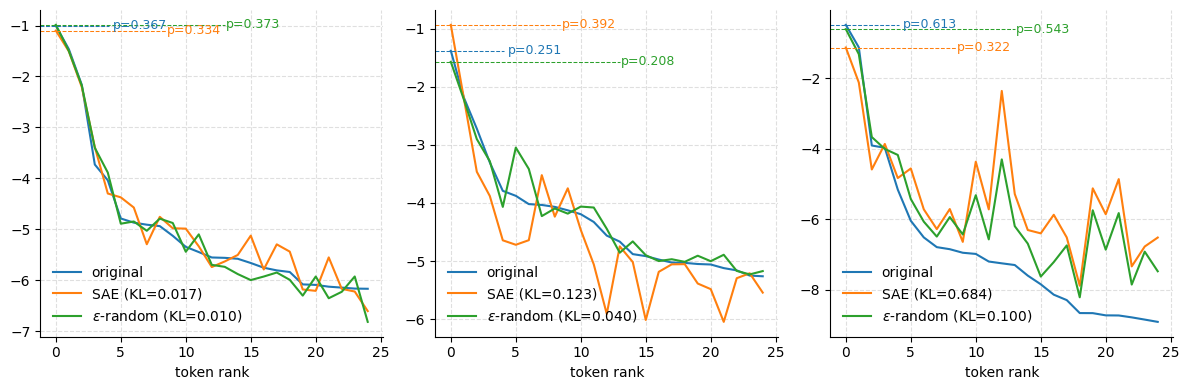

In [114]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

ixs = [2, 9, 16]
for i, ax in zip(ixs, axs):
    plot_top_token_kl_comparison(
        nominal_logits, sae_logits, random_logits, seq=i, pos=64, k=25, ax=ax
    )
    if i == 0:
        ax.set_ylabel('predicted log probability')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(linestyle='--', alpha=0.4)
    
plt.tight_layout()

In [7]:
def create_ablation_hooks(sae_out, pos=None):
    ablation_hooks = [
        (
            'substitution', 
            partial(reconstruction_hook, sae_out=sae_out, pos=pos)),
        (
            'norm_corrected_substitution', 
            partial(reconstruction_w_norm_correction_hook, sae_out=sae_out, pos=pos)),
        (
            'cos_corrected_substitution', 
            partial(reconstruction_w_cos_correction_hook, sae_out=sae_out, pos=pos)),
        (
            'l2_error_preserving_substitution', 
            partial(l2_error_preserving_perturbation_hook, sae_out=sae_out, pos=pos)),
        (
            'cos_preserving_substitution_w_sae_norm', 
            partial(cos_preserving_perturbation_hook, sae_out=sae_out, pos=pos, preserve_sae_norm=True)),
        (
            'cos_preserving_substitution_w_true_norm', 
            partial(cos_preserving_perturbation_hook, sae_out=sae_out, pos=pos, preserve_sae_norm=False)),
        (
            'zero_ablation',
            partial(zero_ablation_hook, pos=pos)),
        (
            'mean_ablation', 
            partial(mean_ablation_hook, pos=pos))
    ]
    return ablation_hooks

In [9]:
import tqdm
sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

dataloader = torch.utils.data.DataLoader(
    token_tensor,
    batch_size=32,
    shuffle=False
)

result_dfs = []
for ix, batch_tokens in enumerate(tqdm.tqdm(dataloader)):
    with torch.inference_mode():
        _, cache = model.run_with_cache(
            batch_tokens, 
            prepend_bos=True,
            names_filter=[sae.cfg.hook_point]
        )
        sae_out, feature_acts, loss, mse_loss, l1_loss, _ = sae(
            cache[sae.cfg.hook_point]
        )
        ablation_hooks = create_ablation_hooks(sae_out)
        
        batch_result_df = run_all_ablations(model, batch_tokens, ablation_hooks, layer=layer)
        
        l0 = (feature_acts > 0).float().sum(dim=-1).cpu().numpy()[:, :-1].flatten()
        l1 = feature_acts.abs().sum(dim=-1).cpu().numpy()[:, :-1].flatten()
        reconstruction_error = (cache[sae.cfg.hook_point] - sae_out).norm(dim=-1).cpu().numpy()[:, :-1].flatten()
        
        batch_result_df['sae_l0'] = l0
        batch_result_df['sae_l1'] = l1
        batch_result_df['reconstruction_error'] = reconstruction_error
        
        batch_result_df['norm'] = feature_acts.norm(dim=-1).cpu().numpy()[:, :-1].flatten()
        batch_result_df['sae_norm'] = sae_out.norm(dim=-1).cpu().numpy()[:, :-1].flatten()
        
        batch_result_df['cos'] = cos_sim(feature_acts, sae_out).cpu().numpy()[:, :-1].flatten()
        
        result_dfs.append(batch_result_df)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


(array([1.060e+02, 8.650e+02, 1.987e+03, 8.780e+02, 2.070e+02, 4.300e+01,
        5.000e+00, 1.000e+00, 2.000e+00, 2.000e+00]),
 array([4.06901054e-05, 8.74837278e-04, 1.70898449e-03, 2.54313159e-03,
        3.37727880e-03, 4.21142625e-03, 5.04557323e-03, 5.87972067e-03,
        6.71386765e-03, 7.54801510e-03, 8.38216208e-03]),
 <BarContainer object of 10 artists>)

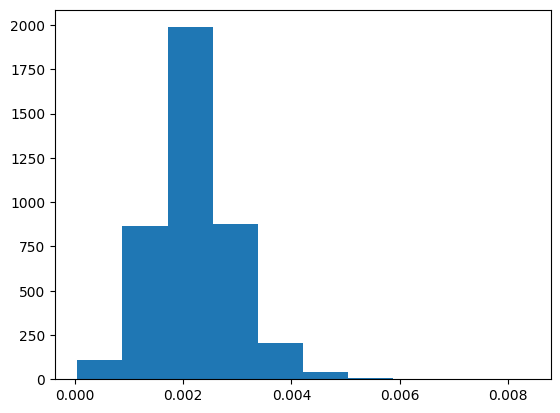

In [27]:
plt.hist((feature_acts > 0).float().mean(dim=-1).cpu().numpy().flatten())

In [16]:
batch_result_df

,token,position,loss,substitution_loss,substitution_kl,norm_corrected_substitution_loss,norm_corrected_substitution_kl,cos_corrected_substitution_loss,cos_corrected_substitution_kl,l2_error_preserving_substitution_loss,l2_error_preserving_substitution_kl,cos_preserving_substitution_w_sae_norm_loss,cos_preserving_substitution_w_sae_norm_kl,cos_preserving_substitution_w_true_norm_loss,cos_preserving_substitution_w_true_norm_kl,zero_ablation_loss,zero_ablation_kl,mean_ablation_loss,mean_ablation_kl
0,50256,0,8.501802,8.616887,0.003332,8.632053,0.004148,8.486570,1.961000e-04,8.561043,0.004330,8.458052,0.004029,8.366830,0.003700,32.510971,17.864429,17.980040,5.087339
1,10161,1,3.087367,3.465445,0.277592,3.518415,0.315134,3.162237,5.487540e-03,3.113410,0.064906,3.255931,0.061797,3.195166,0.042081,37.341156,23.372990,19.210079,10.915838
2,8723,2,8.263130,7.712481,0.305050,7.740900,0.301664,8.260294,3.008432e-04,8.232740,0.076154,9.216182,0.178823,9.707858,0.123871,25.332317,13.741541,14.932919,4.805162
3,17431,3,5.121231,7.106947,0.436749,7.141173,0.425214,4.927605,4.803415e-03,5.695037,0.127235,4.210670,0.874032,4.824384,0.274355,25.094700,25.073626,12.921168,10.550570
4,2577,4,3.845676,3.410742,0.162492,3.574303,0.206467,3.755351,6.076298e-03,5.013739,0.421952,3.681221,0.124096,4.419331,0.106480,5.815308,7.212576,6.165900,2.584125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4059,886,122,0.304087,0.729397,0.242783,0.796987,0.289680,0.295324,7.011076e-04,0.347243,0.015920,0.388213,0.026782,0.305829,0.058889,6.317708,5.794748,3.048855,2.600667
4060,13,123,0.681232,0.688974,0.036728,0.720074,0.039223,0.656129,6.300174e-04,0.713924,0.012172,0.737210,0.018226,0.855916,0.037554,6.972838,11.668982,3.913295,4.621395
4061,198,124,0.000278,0.000305,0.000006,0.000304,0.000006,0.000272,3.780538e-07,0.000251,0.000002,0.000305,0.000002,0.000282,0.000002,6.972846,6.969745,3.913296,3.910258
4062,198,125,5.149232,4.919920,0.049858,4.945456,0.051100,5.119994,5.705841e-04,5.148180,0.014324,5.105373,0.015343,5.153372,0.015779,22.200348,22.023937,10.023597,7.996297


In [12]:
rdf = pd.concat(result_dfs).reset_index(drop=True)

In [13]:
rdf

,token,position,loss,substitution_loss,substitution_kl,norm_corrected_substitution_loss,norm_corrected_substitution_kl,cos_corrected_substitution_loss,cos_corrected_substitution_kl,l2_error_preserving_substitution_loss,...,cos_preserving_substitution_w_sae_norm_kl,cos_preserving_substitution_w_true_norm_loss,cos_preserving_substitution_w_true_norm_kl,zero_ablation_loss,zero_ablation_kl,mean_ablation_loss,mean_ablation_kl,sae_l0,sae_l1,reconstruction_error
0,50256,0,3.278100,3.365619,0.003332,3.377289,0.004148,3.266360,0.000196,3.326998,...,0.003323,3.307721,0.002930,23.309206,17.864429,10.861161,5.289989,12.0,2989.934570,9.478313
1,464,1,8.601232,8.597129,0.001808,8.591522,0.001902,8.605782,0.000013,8.548128,...,0.001718,8.560454,0.002859,20.028505,10.940558,9.396643,3.150976,12.0,57.294678,6.016648
2,9317,2,0.065391,0.108487,0.026610,0.099839,0.024297,0.074906,0.000741,0.048443,...,0.017043,0.092373,0.029732,14.095943,13.112624,9.932951,9.284629,46.0,143.465042,22.473757
3,6241,3,0.074480,0.035457,0.035550,0.032797,0.032824,0.066222,0.001016,0.084654,...,0.070082,0.147799,0.027724,7.681902,7.178787,4.543418,4.312921,68.0,207.695786,35.210403
4,416,4,0.000662,0.980144,0.975135,1.081219,1.076154,0.000652,0.000012,0.084818,...,0.024589,0.074186,0.071151,17.004158,16.999342,12.962061,12.953909,48.0,153.039154,28.940012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20315,3827,122,5.492217,5.356453,0.095679,5.420823,0.091050,5.506985,0.001906,5.783123,...,0.085806,5.184999,0.039774,18.672470,10.363333,11.906652,4.560592,52.0,87.077568,18.964722
20316,260,123,0.874323,1.229926,0.090232,1.199994,0.078357,0.972567,0.005554,0.705704,...,0.102982,0.948640,0.083702,29.714386,27.507723,14.765440,14.092377,44.0,149.411667,23.746311
20317,27362,124,0.304636,0.726356,0.160800,0.816106,0.207933,0.255299,0.005097,0.410237,...,0.073635,0.388890,0.036224,3.433856,2.733171,4.747875,3.386716,76.0,139.020065,29.814840
20318,284,125,1.503809,1.778435,0.104800,1.771717,0.106756,1.504660,0.001246,1.526421,...,0.057186,1.507414,0.047653,3.659952,8.326472,4.387382,3.008460,60.0,78.066437,21.944275


In [11]:
rdf[[c for c in rdf.columns if 'loss' in c]].describe().T.iloc[:-2].style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
loss,203200.000000,3.569470,3.166067,-0.000000,0.982403,2.784680,5.459197,26.582905
substitution_loss,203200.000000,3.706032,3.107372,0.000002,1.207767,2.982711,5.581646,22.709108
norm_corrected_substitution_loss,203200.000000,3.714515,3.091204,0.000001,1.234312,3.005651,5.585448,21.791985
cos_corrected_substitution_loss,203200.000000,3.572845,3.182829,-0.000000,0.967197,2.781228,5.473478,26.828659
l2_error_preserving_substitution_loss,203200.000000,3.629380,3.152740,-0.000000,1.063795,2.870065,5.525341,24.732115
cos_preserving_substitution_w_sae_norm_loss,203200.000000,3.635755,3.176852,-0.000000,1.047322,2.862428,5.537519,27.271933
cos_preserving_substitution_w_true_norm_loss,203200.000000,3.632798,3.160575,0.000002,1.061448,2.866660,5.525335,25.097034


In [12]:
rdf[[c for c in rdf.columns if 'kl' in c]].describe().T.iloc[:-2].style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
substitution_kl,203200.000000,0.154157,0.257341,0.000000,0.042858,0.087331,0.169560,7.360687
norm_corrected_substitution_kl,203200.000000,0.162968,0.264985,0.000000,0.046117,0.093507,0.180455,7.115581
cos_corrected_substitution_kl,203200.000000,0.002826,0.005609,-0.000001,0.000626,0.001467,0.003091,0.318359
l2_error_preserving_substitution_kl,203200.000000,0.061070,0.096277,-0.000000,0.018554,0.037584,0.070902,7.311724
cos_preserving_substitution_w_sae_norm_kl,203200.000000,0.068346,0.110856,0.000000,0.019913,0.040624,0.077431,5.145217
cos_preserving_substitution_w_true_norm_kl,203200.000000,0.065101,0.104925,0.000000,0.019106,0.039072,0.074313,5.751326


In [13]:
rdf['sub_minus_nominal_loss'] = rdf['substitution_loss'] - rdf['loss']

In [14]:
rdf.sort_values('sub_minus_nominal_loss', ascending=False)

,token,position,loss,substitution_loss,substitution_kl,norm_corrected_substitution_loss,norm_corrected_substitution_kl,cos_corrected_substitution_loss,cos_corrected_substitution_kl,l2_error_preserving_substitution_loss,l2_error_preserving_substitution_kl,cos_preserving_substitution_w_sae_norm_loss,cos_preserving_substitution_w_sae_norm_kl,cos_preserving_substitution_w_true_norm_loss,cos_preserving_substitution_w_true_norm_kl,zero_ablation_loss,zero_ablation_kl,mean_ablation_loss,mean_ablation_kl,sub_minus_nominal_loss
2704,2678,37,4.741143,15.618616,7.360687,15.374580,7.113778,4.861415,0.001080,4.337602,0.039094,4.487770,0.011757,5.103289,0.029001,14.054718,6.644119,10.622816,4.999538,10.877473
1115,247,99,4.990436,13.880573,2.356997,13.852748,2.354004,4.907588,0.017006,4.648955,0.357301,4.442889,0.230498,5.880364,0.185141,18.179268,8.993977,12.964190,4.343982,8.890137
111,4326,111,1.823066,10.615499,3.151180,10.389697,3.058206,1.813610,0.001064,1.445343,0.064060,1.715070,0.043120,3.254289,0.502443,15.591084,6.954307,11.182006,3.402335,8.792434
1935,15073,30,0.224114,8.783925,6.770732,8.101796,6.210496,0.132964,0.040020,3.747747,2.571907,0.914230,0.499978,0.235354,0.342652,24.891499,21.512804,13.137330,10.951006,8.559812
1618,1339,94,5.027034,13.268468,4.162406,13.295370,4.179701,4.921182,0.001257,7.556543,0.749918,7.460637,0.702374,5.851021,0.161747,20.171097,10.853748,12.682889,5.303150,8.241434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,657,15,7.774892,0.238241,3.420618,0.122753,3.673233,8.876784,0.000193,3.564177,0.027182,0.992292,0.531395,3.531216,0.961382,6.972846,15.549669,4.506176,7.232975,-7.536651
854,8646,92,9.808127,0.650292,1.484367,0.353732,1.816421,10.387980,0.000015,2.357804,0.100505,1.850835,0.939231,7.070229,0.000889,6.972850,15.556249,4.506177,7.237295,-9.157835
484,8646,103,10.299988,0.472712,1.246142,0.385881,1.361778,12.292953,0.000042,3.934179,0.020461,1.570696,0.453005,5.320177,0.005299,6.972852,15.556775,4.506177,7.237723,-9.827275
1343,1802,73,10.852107,0.674859,1.818656,0.438941,2.280267,10.438046,0.000119,4.158130,0.067048,5.749329,0.012294,4.367352,0.033232,6.972843,15.555863,4.506178,7.236770,-10.177248


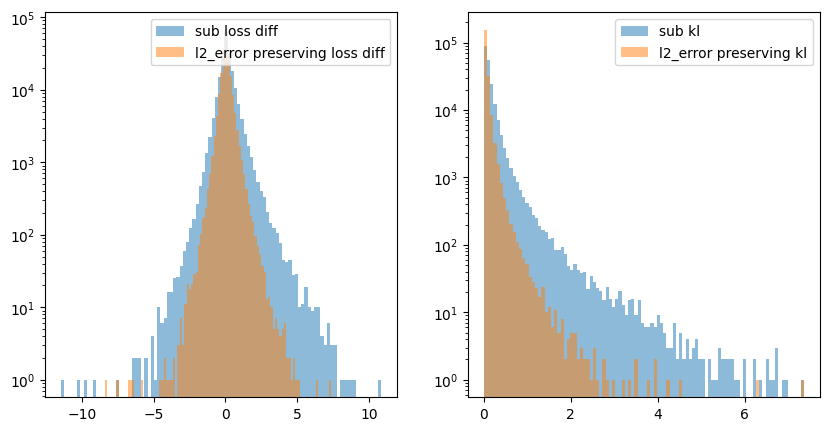

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
ax.hist(rdf['substitution_loss'] - rdf['loss'], bins=100, alpha=0.5, label='sub loss diff');
ax.hist(rdf['l2_error_preserving_substitution_loss'] - rdf['loss'], bins=100, alpha=0.5, label='l2_error preserving loss diff');
ax.legend()
ax.set_yscale('log')

kl_max = max(rdf['substitution_kl'].max(), rdf['l2_error_preserving_substitution_kl'].max())
ax = axs[1]
ax.hist(rdf['substitution_kl'], bins=100, alpha=0.5, label='sub kl', range=(0, kl_max));
ax.hist(rdf['l2_error_preserving_substitution_kl'], bins=100, alpha=0.5, label='l2_error preserving kl', range=(0, kl_max));
ax.legend()
ax.set_yscale('log')

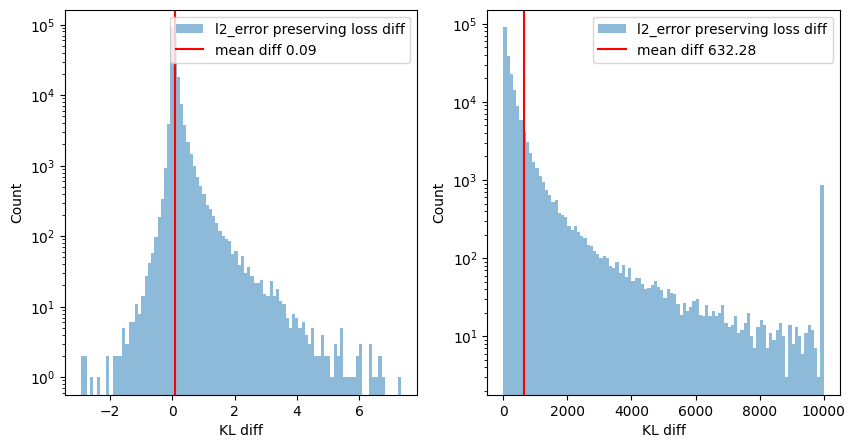

In [20]:
#ax.hist(rdf['substitution_loss'] - rdf['loss'], bins=100, alpha=0.5, label='sub loss diff');
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
ax.hist(rdf['substitution_kl'] - rdf['l2_error_preserving_substitution_kl'], bins=100, alpha=0.5, label='l2_error preserving loss diff');
mean_diff = (rdf['substitution_kl'] - rdf['l2_error_preserving_substitution_kl']).mean()
ax.set_yscale('log')
ax.set_xlabel('KL diff')
ax.set_ylabel('Count')
ax.axvline(mean_diff, color='r', label=f'mean diff {mean_diff:.2f}')
ax.legend()

ax = axs[1]
# same plot but with relative differences
relative_kl_increase = (rdf['substitution_kl'] - rdf['l2_error_preserving_substitution_kl']) / rdf['l2_error_preserving_substitution_kl'] * 100
ax.hist(np.clip(relative_kl_increase, 0, 10000), bins=100, alpha=0.5, label='l2_error preserving loss diff');
mean_diff = relative_kl_increase.mean()
ax.set_yscale('log')
ax.set_xlabel('KL diff')
ax.set_ylabel('Count')
ax.axvline(mean_diff, color='r', label=f'mean diff {mean_diff:.2f}')
ax.legend()


In [24]:
loss_by_pos = rdf.groupby('position')[[c for c in rdf.columns if 'kl' in c and 'zero' not in c and 'mean' not in c]].mean()
px.line(loss_by_pos, title="KL by position").show()

In [70]:
errors = einops.rearrange((act - sae_out)[1:], "batch seq dim -> (batch seq) dim")

In [71]:
# error pca
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(errors.cpu().numpy())

PCA()

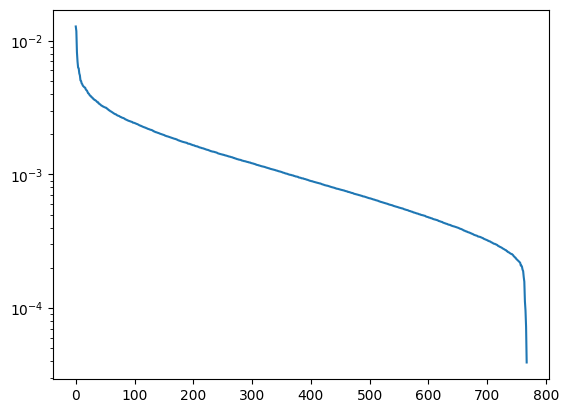

In [82]:
plt.plot(pca.explained_variance_ratio_)
plt.yscale('log')